In [1]:
%matplotlib inline

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, Aer
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd
from typing import List
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator

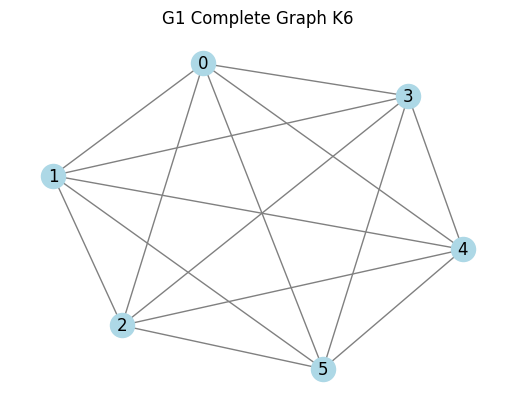

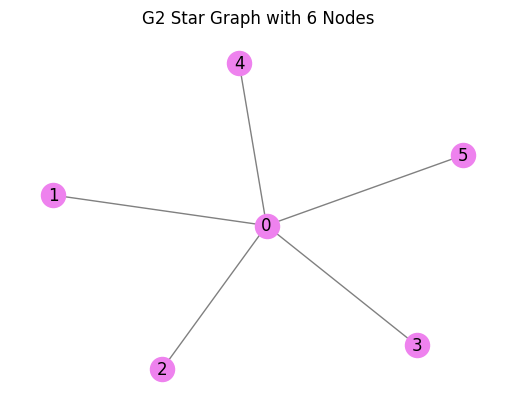

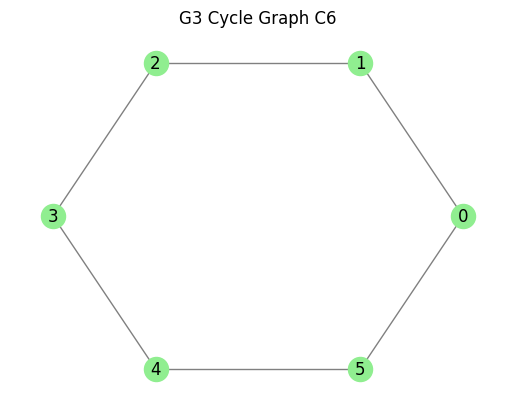

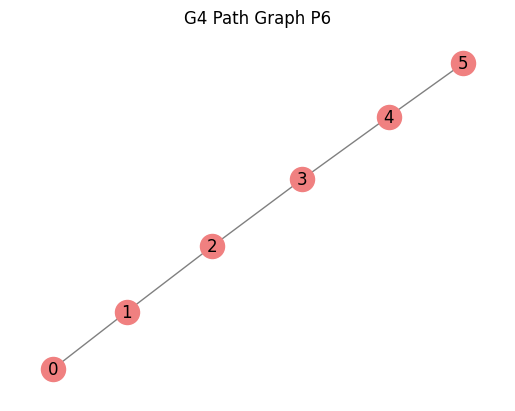

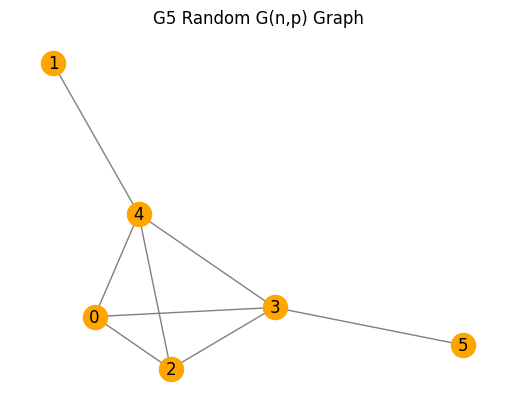

In [22]:
def complete_graph_k6():
    G = nx.complete_graph(6)
    pos = nx.spring_layout(G)
    fig, ax = plt.subplots() 
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', edge_color='gray')
    ax.set_title("G1 Complete Graph K6")
    plt.show()
    return G

def star_graph_6():
    G = nx.star_graph(5)
    pos = nx.spring_layout(G)
    fig, ax = plt.subplots()
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='violet', edge_color='gray')
    ax.set_title("G2 Star Graph with 6 Nodes")
    plt.show()
    return G

def cycle_graph_c6():
    G = nx.cycle_graph(6)
    pos = nx.circular_layout(G)
    fig, ax = plt.subplots()
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightgreen', edge_color='gray')
    ax.set_title("G3 Cycle Graph C6")
    plt.show()
    return G

def path_graph_p6():
    G = nx.path_graph(6)
    pos = nx.spring_layout(G)  # 또는 nx.shell_layout(G), nx.circular_layout(G)
    fig, ax = plt.subplots()
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightcoral', edge_color='gray')
    ax.set_title("G4 Path Graph P6")
    plt.show()
    return G

def random_graph_gnp(n=6, p=0.4, seed=42):
    G = nx.erdos_renyi_graph(n, p, seed=seed)
    pos = nx.spring_layout(G)
    fig, ax = plt.subplots()
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='orange', edge_color='gray')
    ax.set_title("G5 Random G(n,p) Graph")
    plt.show()
    return G

G1 = complete_graph_k6()
G2 = star_graph_6()
G3 = cycle_graph_c6()
G4 = path_graph_p6()
G5 = random_graph_gnp()

5
Greedy bitstring: 010101

=== QPE 결과 (Top-10) ===
1. bits 11001101  freq 273614  E_QPE ≈ -1.992
2. bits 10110011  freq 273163  E_QPE ≈ -3.008
3. bits 11100110  freq 89768  E_QPE ≈ -1.016
4. bits 10011010  freq 89330  E_QPE ≈ -3.984
5. bits 10011001  freq 39938  E_QPE ≈ -4.023
6. bits 11100111  freq 39838  E_QPE ≈ -0.977
7. bits 10000000  freq 31471  E_QPE ≈ -5.000
8. bits 00000000  freq 31209  E_QPE ≈ 0.000
9. bits 11001100  freq 17157  E_QPE ≈ -2.031
10. bits 10110100  freq 17091  E_QPE ≈ -2.969


C:\Users\SJH\AppData\Local\Temp\ipykernel_36468\3507073276.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, title="QPE Phase Estimation",figsize=(20, 5)).show()


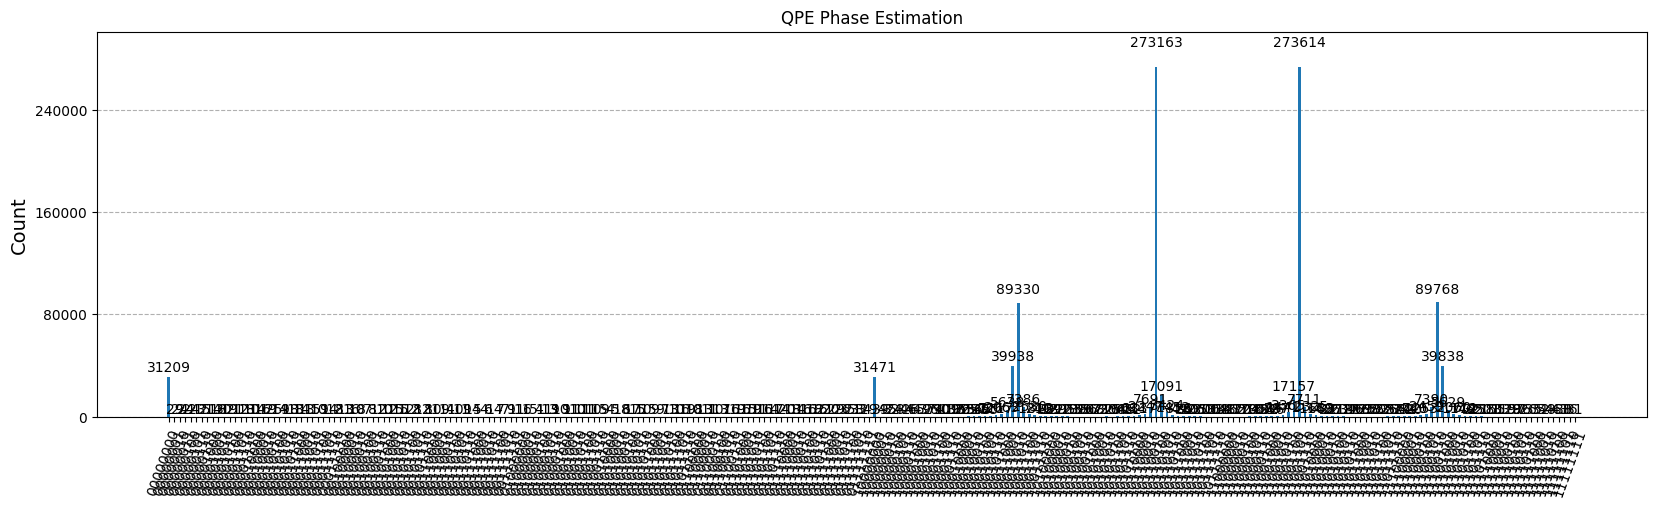

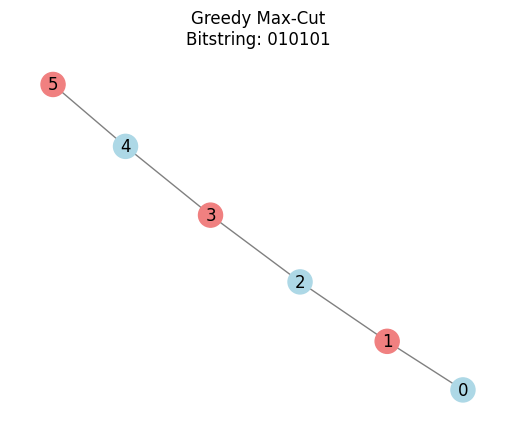


[QPE Estimated Eigenvalue] E ≈ -1.99219
[Closest True Eigenvalue] E = -2.00000
[Most Probable State in Eigenvector] |100001⟩  with prob = 1.000


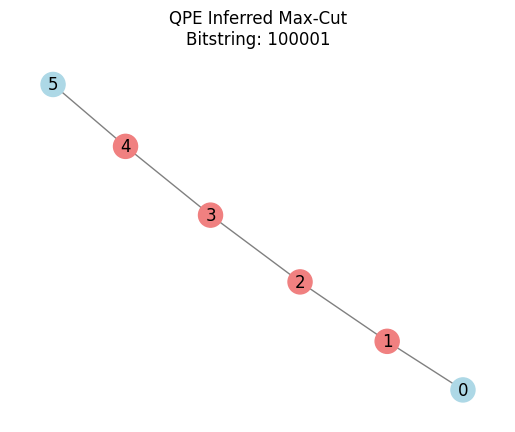

In [ ]:
def build_maxcut_hamiltonian(graph: nx.Graph) -> SparsePauliOp:
    """
    Build the MaxCut Hamiltonian: H = (|E|/2)*I - (1/2)*Σ_{(i,j)∈E}(Z_i Z_j)
    """
    num_qubits = len(graph.nodes)
    edges = list(graph.edges())
    num_edges = len(edges)

    pauli_terms = ["I" * num_qubits]
    coeffs = [-num_edges / 2]

    for (u, v) in edges:
        z_term = ["I"] * num_qubits
        z_term[u] = "Z"
        z_term[v] = "Z"
        pauli_terms.append("".join(z_term))
        coeffs.append(0.5)

    return SparsePauliOp.from_list(list(zip(pauli_terms, coeffs)))

def greedy_maxcut(graph: nx.Graph) -> str:
    n = graph.number_of_nodes()
    edges = list(graph.edges())

    def energy(bits):
        z = 1 - 2*np.array(bits)
        return -0.5 * sum(1 - z[i]*z[j] for (i,j) in edges)

    bits = [0]*n
    improved = True
    while improved:
        improved = False
        for i in range(n):
            test = bits.copy()
            test[i] ^= 1
            if energy(test) < energy(bits):
                bits = test
                improved = True
    return ''.join(map(str, bits[::-1]))

def create_qpe_circuit(num_ancilla: int, U_gate: UnitaryGate, state_prep: QuantumCircuit) -> QuantumCircuit:
    n_target = state_prep.num_qubits
    U_mat = U_gate.to_matrix()
    qc = QuantumCircuit(num_ancilla + n_target, num_ancilla)
    qc.h(range(num_ancilla))
    qc.compose(state_prep, qubits=range(num_ancilla, num_ancilla+n_target), inplace=True)
    for j in range(num_ancilla):
        mat_pow = np.linalg.matrix_power(U_mat, 2**j)
        qc.append(UnitaryGate(mat_pow).control(), [j] + list(range(num_ancilla, num_ancilla+n_target)))
    qc.compose(QFT(num_ancilla, do_swaps=True).inverse(), range(num_ancilla), inplace=True)
    qc.measure(range(num_ancilla), range(num_ancilla))
    return qc

def bit_to_E(bs, t, T):
    phi = int(bs, 2) / 2**t
    if phi >= 0.5:
        phi -= 1.0
    return (2 * np.pi * phi) / T

def visualize_maxcut_solution(graph: nx.Graph, bitstring: str, title="Max-Cut Visualization"):
    color_map = ['lightcoral' if bit == '0' else 'lightblue' for bit in bitstring[::-1]]
    pos = nx.spring_layout(graph, seed=42)
    fig, ax = plt.subplots()
    nx.draw(graph, pos, ax=ax, with_labels=True, node_color=color_map, edge_color='gray')
    ax.set_title(f"{title}\nBitstring: {bitstring}")
    plt.show()

def run_qpe_on_graph(graph: nx.Graph, t: int = 8, shots: int = 1000000):
    nq = graph.number_of_nodes()
    H = build_maxcut_hamiltonian(graph)
    H_mat = Operator(H).data
    E_bound = graph.number_of_edges()
    T = np.pi / E_bound
    print(E_bound)
    bit_guess = greedy_maxcut(graph)
    print("Greedy bitstring:", bit_guess)

    state_prep = QuantumCircuit(nq)
    state_prep.h(range(len(bit_guess)))

    
    U = expm(1j * T * H_mat)
    U_gate = UnitaryGate(U, label="e^{iTH}")

    qpe = create_qpe_circuit(t, U_gate, state_prep)
    backend = AerSimulator()
    counts = backend.run(transpile(qpe, backend), shots=shots).result().get_counts()

    print("\n=== QPE 결과 (Top-10) ===")
    for i, (bs, f) in enumerate(sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:10], 1):
        print(f"{i}. bits {bs}  freq {f:4d}  E_QPE ≈ {bit_to_E(bs, t, T):.3f}")

    plot_histogram(counts, title="QPE Phase Estimation",figsize=(20, 5)).show()
    

    top_bitstring = max(counts, key=counts.get)
    visualize_maxcut_solution(graph, bit_guess, title="Greedy Max-Cut")
    return bit_guess, top_bitstring

def visualize_qpe_eigenvector_maxcut(graph: nx.Graph, top_bitstring: str, t: int, T: float, H_mat: np.ndarray):

    phi_hat = int(top_bitstring, 2) / 2**t
    if phi_hat >= 0.5:
        phi_hat -= 1
    E_hat = (2 * np.pi * phi_hat) / T
    print(f"\n[QPE Estimated Eigenvalue] E ≈ {E_hat:.5f}")

    eigvals, eigvecs = np.linalg.eigh(H_mat)
    idx_closest = np.argmin(np.abs(eigvals - E_hat))
    true_E = eigvals[idx_closest]
    v = eigvecs[:, idx_closest]
    print(f"[Closest True Eigenvalue] E = {true_E:.5f}")

    probs = np.abs(v) ** 2
    max_idx = np.argmax(probs)
    n_qubits = int(np.log2(len(H_mat)))
    measured_bitstring = f"{max_idx:0{n_qubits}b}"
    print(f"[Most Probable State in Eigenvector] |{measured_bitstring}⟩  with prob = {probs[max_idx]:.3f}")

    visualize_maxcut_solution(graph, measured_bitstring, title="QPE Inferred Max-Cut")


bit_guess, top_bitstring = run_qpe_on_graph(G4)

H = build_maxcut_hamiltonian(G4)
H_mat = Operator(H).data
E_bound = G4.number_of_edges()
T = np.pi / E_bound
t = 8 

visualize_qpe_eigenvector_maxcut(G4, top_bitstring, t, T, H_mat)